In [1]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from IPython.display import clear_output

In [2]:
# hyperparams
inp_dim = 28 * 28
#try to use other model params. check overfitting with large models
hidden = 350
out_dim = 60
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 3
batch_size = 128

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])


dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
#@title
dataset_test[555]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [ ]:
class Encoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_dim, hidden_dim, out_dim):
    super().__init__()
    #TODO try to use other layers
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.do = nn.Dropout(0.1)
    self.activ = nn.ReLU()
    self.linear2 = nn.Linear(hidden_dim, out_dim)

  def forward(self, x):
    x = self.activ(self.do(self.linear1(x)))

    return self.linear2(x)

class Decoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_dim, hidden_dim, out_dim):
    super().__init__()
    #TODO try to use other layers
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.do = nn.Dropout(0.1)
    self.activ = nn.ReLU()
    self.linear2 = nn.Linear(hidden_dim, out_dim)

  def forward(self, x):
    x = self.activ(self.do(self.linear1(x)))

    return self.linear2(x)

class LinearAutoEncoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, out_dim):
    super().__init__()
    self.encoder = Encoder(input_dim, hidden_dim, out_dim)
    self.decoder = Decoder(out_dim, hidden_dim, input_dim)

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_


# #Linear encoder TODO try to use MAE

In [ ]:

loss_func1 = nn.MSELoss() #TODO try to use MAE
loss_func2 = nn.L1Loss()

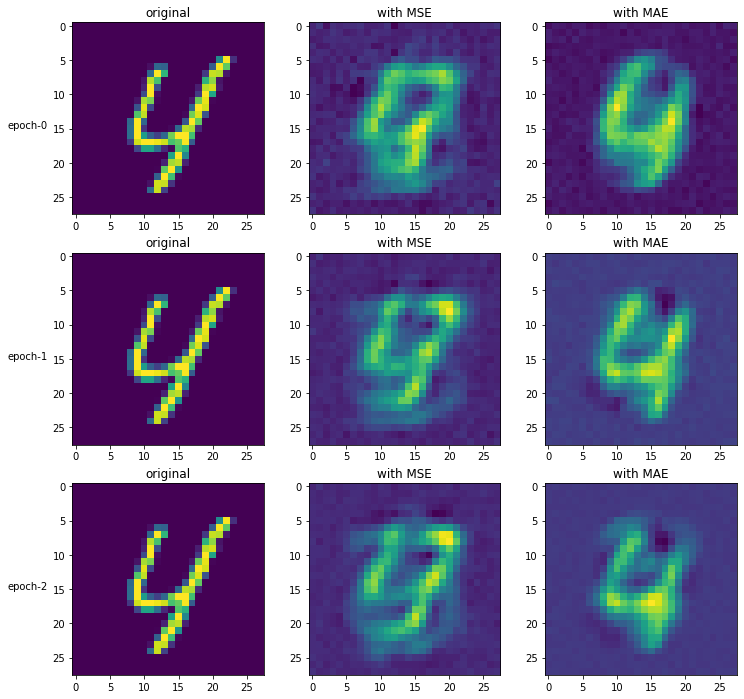

In [ ]:
#hidden_out = 40
fig, ax = plt.subplots(nrows=3, ncols=3)   
fig.set_size_inches(12,12)

#with MSE
model = LinearAutoEncoder(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model.parameters())
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        target = inputs.view(inputs.size(0), -1).to(device)
        predict = model(target)
        loss = loss_func1(target, predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test.data[555].unsqueeze(0).view(1, -1).to(device).float()#
      

    ax[epoch][0].imshow(dataset_test.data[555])
    ax[epoch][0].text(-10, 15, 'epoch-'+str(epoch))
    ax[epoch][0].set_title('original')
    ax[epoch][1].imshow(model(item).view((28, 28)).cpu().detach().numpy())
    ax[epoch][1].set_title('with MSE')

    torch.save(model.state_dict(), f'./lin1_ae_chkpt_{epoch}.pth')

#with MAE
model2 = LinearAutoEncoder(inp_dim, hidden, out_dim).to(device)
optim2 = torch.optim.Adam(model2.parameters())
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim2.zero_grad()
        target = inputs.view(inputs.size(0), -1).to(device)
        predict = model2(target)
        loss = loss_func2(target, predict)
        loss.backward()
        optim2.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test.data[555].unsqueeze(0).view(1, -1).to(device).float()#

    ax[epoch][2].imshow(model2(item).view((28, 28)).cpu().detach().numpy())
    ax[epoch][2].set_title('with MAE')

    torch.save(model.state_dict(), f'./lin2_ae_chkpt_{epoch}.pth')

plt.show()




    

In [ ]:
input_channels = 1
hidden_channels = 64

In [ ]:
class ConvEncoder(nn.Module):
  #28x28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=1, 
                           padding=2)
    self.do1 = nn.Dropout(0.1)
    self.pool1 = nn.MaxPool2d((2, 2)) # 14 x 14

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.do2 = nn.Dropout(0.1)
    self.pool2 = nn.MaxPool2d((2, 2)) # 7 x 7
    self.conv3 = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.conv1(x))))
    x = self.pool2(self.do2(self.activ(self.conv2(x))))

    return self.conv3(x)

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.do1 = nn.Dropout(0.1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14 x 14

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.do2 = nn.Dropout(0.1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28
    self.conv3 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1, 
                           padding=2)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.conv1(x))))
    x = self.upsample2(self.do2(self.activ(self.conv2(x))))

    return self.conv3(x)

class ConvAutoEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_


##Convolutional encoder TODO try to use MAE

In [ ]:

loss_func1 = nn.MSELoss() #TODO try to use MAE
loss_func2 = nn.L1Loss()


epoch: 0, step: 0, loss: 0.9281662702560425
epoch: 0, step: 200, loss: 0.08376585692167282
epoch: 0, step: 400, loss: 0.06435401737689972
epoch: 1, step: 0, loss: 0.06110017001628876
epoch: 1, step: 200, loss: 0.05281853675842285
epoch: 1, step: 400, loss: 0.04939206689596176
epoch: 2, step: 0, loss: 0.04696259647607803
epoch: 2, step: 200, loss: 0.044242653995752335
epoch: 2, step: 400, loss: 0.04481542110443115
epoch: 3, step: 0, loss: 0.042043767869472504
epoch: 3, step: 200, loss: 0.04073468595743179
epoch: 3, step: 400, loss: 0.04254727438092232
epoch: 0, step: 0, loss: 0.9492510557174683
epoch: 0, step: 200, loss: 0.19946685433387756
epoch: 0, step: 400, loss: 0.18247918784618378
epoch: 1, step: 0, loss: 0.17347000539302826
epoch: 1, step: 200, loss: 0.16082479059696198
epoch: 1, step: 400, loss: 0.14609859883785248
epoch: 2, step: 0, loss: 0.1449202001094818
epoch: 2, step: 200, loss: 0.147065669298172
epoch: 2, step: 400, loss: 0.14090564846992493
epoch: 3, step: 0, loss: 0.135

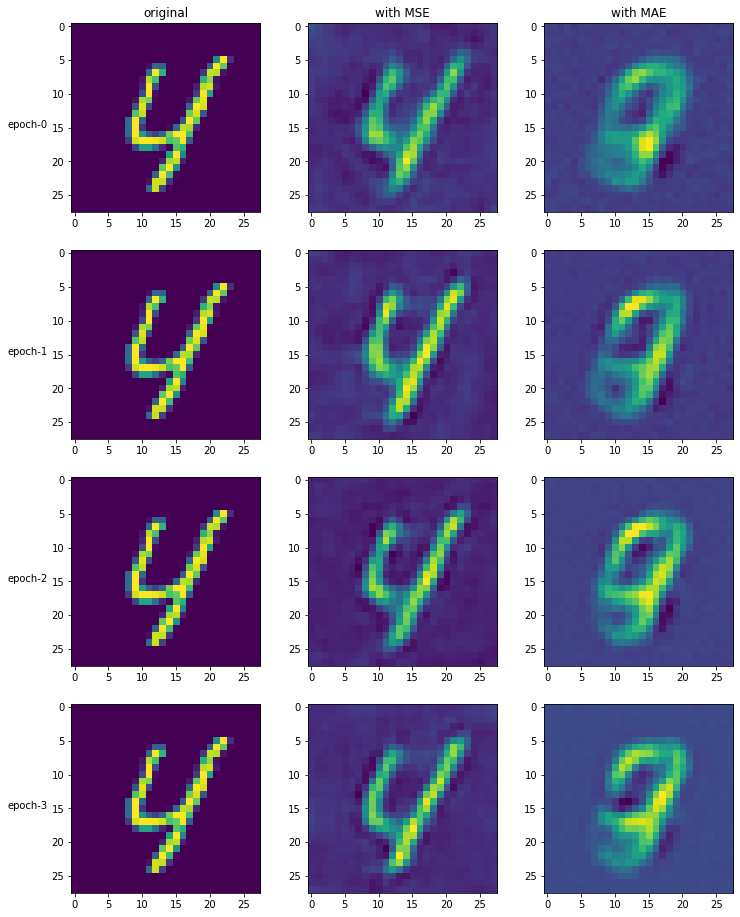

In [ ]:
n_epochs = 4
fig, ax = plt.subplots(nrows=n_epochs, ncols=3)   
fig.set_size_inches(12, n_epochs*4)
#with MSE
model1 = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim1 = torch.optim.Adam(model1.parameters())
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim1.zero_grad()

        predict = model1(inputs.to(device))
        loss = loss_func1(inputs.to(device), predict)
        loss.backward()
        optim1.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[555][0].unsqueeze(0).to(device).float()

    ax[epoch][0].imshow(dataset_test.data[555])#.detach().numpy())
    ax[epoch][0].text(-10, 15, 'epoch-'+str(epoch))
    ax[epoch][1].imshow(model1(item).view((28, 28)).cpu().detach().numpy())
    ax[epoch][0].set_title('original')
    ax[epoch][1].set_title('with MSE')

    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')

#with MAE
model2 = LinearAutoEncoder(inp_dim, hidden, out_dim).to(device)
optim2 = torch.optim.Adam(model2.parameters())
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim2.zero_grad()
        target = inputs.view(inputs.size(0), -1).to(device)
        predict = model2(target)
        loss = loss_func2(target, predict)
        loss.backward()
        optim2.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test.data[555].unsqueeze(0).view(1, -1).to(device).float()#
      
    ax[epoch][2].imshow(model2(item).view((28, 28)).cpu().detach().numpy())
    ax[epoch][2].set_title('with MAE')
    torch.save(model.state_dict(), f'./lin2_ae_chkpt_{epoch}.pth')





plt.show()

# #Noize input TODO try to use MAE

epoch: 0, step: 0, loss: 0.9430723786354065
epoch: 0, step: 200, loss: 0.10390499234199524
epoch: 0, step: 400, loss: 0.08594387024641037
epoch: 1, step: 0, loss: 0.07726190239191055
epoch: 1, step: 200, loss: 0.07248865067958832
epoch: 1, step: 400, loss: 0.07275088131427765
epoch: 2, step: 0, loss: 0.06735925376415253
epoch: 2, step: 200, loss: 0.06560275703668594
epoch: 2, step: 400, loss: 0.060184113681316376
epoch: 3, step: 0, loss: 0.059545546770095825
epoch: 3, step: 200, loss: 0.06085854023694992
epoch: 3, step: 400, loss: 0.05709872022271156
epoch: 0, step: 0, loss: 0.8840054869651794
epoch: 0, step: 200, loss: 0.23731212317943573
epoch: 0, step: 400, loss: 0.1562257707118988
epoch: 1, step: 0, loss: 0.1566552072763443
epoch: 1, step: 200, loss: 0.14287929236888885
epoch: 1, step: 400, loss: 0.1303740292787552
epoch: 2, step: 0, loss: 0.1286984533071518
epoch: 2, step: 200, loss: 0.12479929625988007
epoch: 2, step: 400, loss: 0.12426109611988068
epoch: 3, step: 0, loss: 0.1235

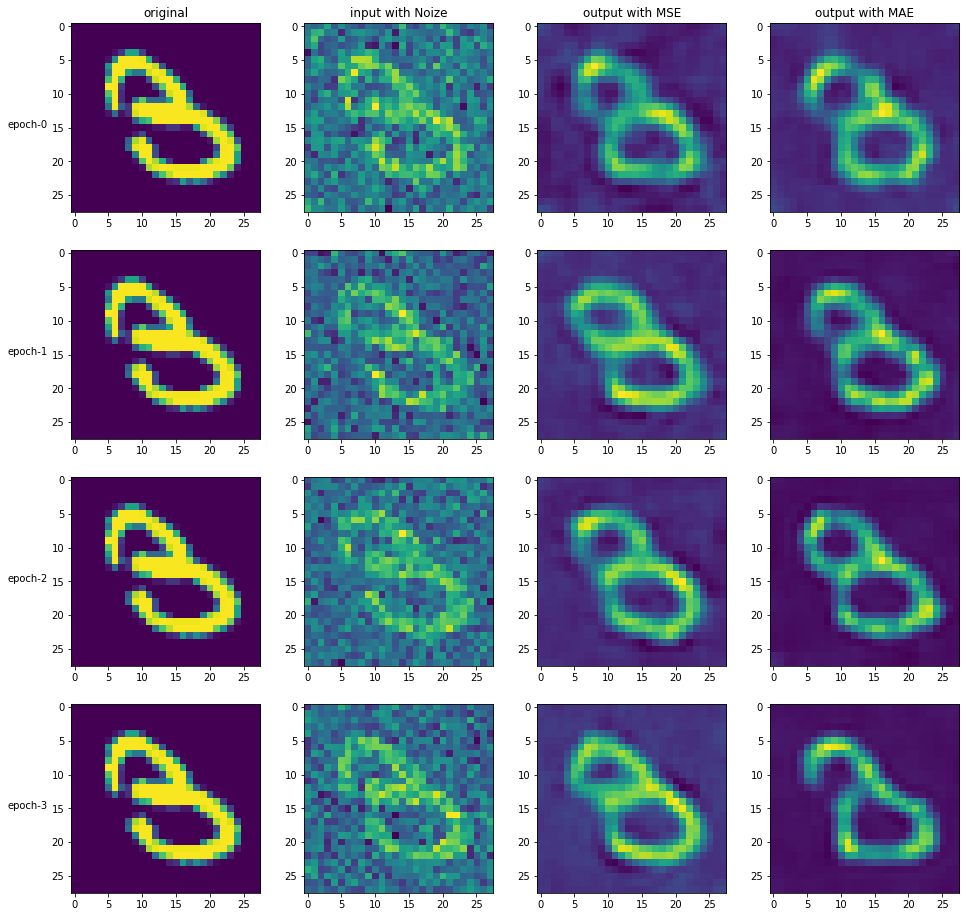

In [ ]:
loss_func1 = nn.MSELoss() #TODO try to use MAE
loss_func2 = nn.L1Loss()

fig, ax = plt.subplots(nrows=n_epochs, ncols=4)   
fig.set_size_inches(16, n_epochs*4)

p_exmpl=18

model1 = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim1 = torch.optim.Adam(model1.parameters())
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim1.zero_grad()
        inputs = inputs.to(device)
        noise_inputs = inputs + \
        torch.normal(torch.zeros_like(inputs), torch.ones_like(inputs)) * 0.7 
        predict = model1(noise_inputs)
        loss = loss_func1(inputs, predict)
        loss.backward()
        optim1.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[p_exmpl][0].unsqueeze(0).to(device).float()
    item = item + torch.normal(torch.zeros_like(item), torch.ones_like(item)) * 0.7

    ax[epoch][0].imshow(dataset_test.data[p_exmpl])
    ax[epoch][0].text(-10, 15, 'epoch-'+str(epoch))
    ax[epoch][1].imshow(item.squeeze().squeeze().cpu().detach().numpy())
    ax[epoch][2].imshow(model1(item).view((28, 28)).cpu().detach().numpy())
    ax[epoch][0].set_title('original')
    ax[epoch][1].set_title('input with Noize')
    ax[epoch][2].set_title('output with MSE')
  
    torch.save(model.state_dict(), f'./cnv1_ae_chkpt_{epoch}.pth')

model2 = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim2 = torch.optim.Adam(model2.parameters())
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim2.zero_grad()
        inputs = inputs.to(device)
        noise_inputs = inputs + \
        torch.normal(torch.zeros_like(inputs), torch.ones_like(inputs)) * 0.7 
        predict = model2(noise_inputs)
        loss = loss_func2(inputs, predict)
        loss.backward()
        optim2.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[p_exmpl][0].unsqueeze(0).to(device).float()
    item = item + torch.normal(torch.zeros_like(item), torch.ones_like(item)) * 0.7

    ax[epoch][3].imshow(model2(item).view((28, 28)).cpu().detach().numpy())    
    ax[epoch][3].set_title('output with MAE')
    torch.save(model.state_dict(), f'./cnv2_ae_chkpt_{epoch}.pth')




plt.show()    

In [ ]:
class ConvVAEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=1, 
                           padding=2) # 28x28
    self.do1 = nn.Dropout(0.1)
    self.pool1 = nn.MaxPool2d(2, 2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do2 = nn.Dropout(0.1)
    self.pool2 = nn.MaxPool2d(2, 2) # 7x7
    self.conv3_mu = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.conv3_sigma = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.conv1(x))))
    x = self.pool2(self.do2(self.activ(self.conv2(x))))
    mu = self.conv3_mu(x)
    sigma = torch.exp(self.conv3_sigma(x))

    return mu, sigma

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.do1 = nn.Dropout(0.1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do2 = nn.Dropout(0.1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28x28
    self.conv3 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1, 
                           padding=2) # 28x28
    self.activ = nn.ReLU()
  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.conv1(x))))
    x = self.upsample2(self.do2(self.activ(self.conv2(x))))
    x = self.conv3(x)


    return x

def sampling(mu, sigma):
    return torch.normal(torch.zeros_like(mu), torch.ones_like(mu)) * sigma + mu

class ConvVAE(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvVAEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    mu, sigma = self.encoder(x)
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden)

    return x_, mu, sigma

# #VAE TODO try to use MAE


epoch: 0, step: 0, loss: 0.9743332862854004
epoch: 0, step: 200, loss: 0.1108018159866333
epoch: 0, step: 400, loss: 0.09257365018129349
epoch: 1, step: 0, loss: 0.08673840016126633
epoch: 1, step: 200, loss: 0.08308219909667969
epoch: 1, step: 400, loss: 0.0738295242190361
epoch: 0, step: 0, loss: 0.9239814281463623
epoch: 0, step: 200, loss: 0.20978742837905884
epoch: 0, step: 400, loss: 0.17359991371631622
epoch: 1, step: 0, loss: 0.1608150750398636
epoch: 1, step: 200, loss: 0.15328219532966614
epoch: 1, step: 400, loss: 0.14278873801231384


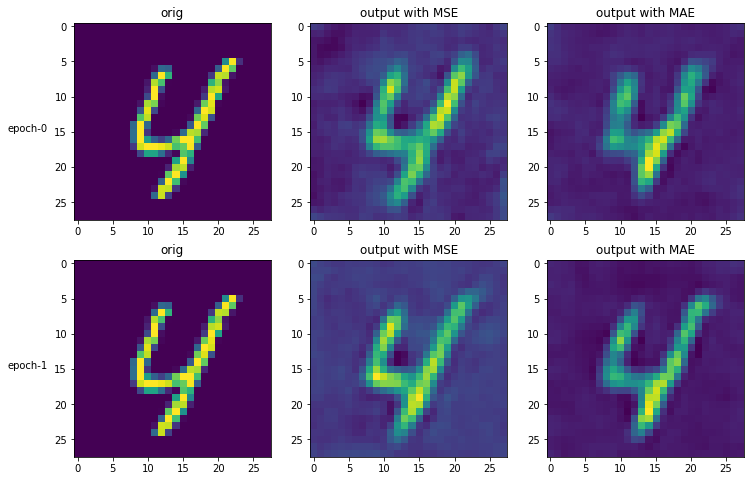

In [ ]:
def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(mu))
    return torch.distributions.kl_divergence(p, q).mean()

p_exmpl=555
n_epochs=2

fig, ax = plt.subplots(nrows=n_epochs, ncols=3)   
fig.set_size_inches(12, n_epochs*4)

loss_func1 = nn.MSELoss() #TODO try to use MAE
loss_func2 = nn.L1Loss()

model1 = ConvVAE(input_channels, hidden_channels).to(device)
optim1 = torch.optim.Adam(model1.parameters())
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim1.zero_grad()
        inputs = inputs.to(device)
        # noise_inputs = inputs + \
        # torch.normal(torch.zeros_like(inputs), torch.ones_like(inputs)) * 0.7 
        predict, mu, sigma = model1(inputs)
        loss = loss_func1(inputs, predict) + 0.01 * kl_loss(mu, sigma)
        loss.backward()
        optim1.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[p_exmpl][0].unsqueeze(0).to(device).float()
    ax[epoch][0].imshow(item.squeeze().squeeze().cpu().detach().numpy())
    ax[epoch][0].text(-10, 15, 'epoch-'+str(epoch))
    ax[epoch][1].imshow(model1(item)[0].squeeze().squeeze().cpu().detach().numpy())
    ax[epoch][0].set_title('orig')
    ax[epoch][1].set_title('output with MSE')

model2 = ConvVAE(input_channels, hidden_channels).to(device)
optim2 = torch.optim.Adam(model2.parameters())
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim2.zero_grad()
        inputs = inputs.to(device)
        # noise_inputs = inputs + \
        # torch.normal(torch.zeros_like(inputs), torch.ones_like(inputs)) * 0.7 
        predict, mu, sigma = model2(inputs)
        loss = loss_func2(inputs, predict) + 0.01 * kl_loss(mu, sigma)
        loss.backward()
        optim2.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}') 
    
    item = dataset_test[p_exmpl][0].unsqueeze(0).to(device).float()   
    ax[epoch][2].imshow(model2(item)[0].squeeze().squeeze().cpu().detach().numpy())
    ax[epoch][2].set_title('output with MAE')


plt.show()


# #TODO дописать до приемлемой генерации

In [17]:
class ConvVAEncoderv2(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    
    #self.linear = nn.LazyLinear(6*6)
    self.linear = nn.LazyLinear(hidden_ch*6*6)

    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=2, padding=0) # 12x12
    self.do1 = nn.Dropout(0.1)
    
    self.pool2 = nn.MaxPool2d(2, 2) # 3x3
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=2, stride=2, padding=0) # 6x6
    self.do2 = nn.Dropout(0.1)

    self.conv3_mu = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=2, padding=1) #2x2
    self.conv3_sigma = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=2, padding=1)  
    
    self.activ = nn.LeakyReLU()

  def forward(self, x):
    x = self.do1(self.activ(self.conv1(x)))
    x = self.do2(self.activ(self.conv2(x)))
    #x1 = self.linear(x.view(x.size(0), -1)).view(x.size(0), 1, 6, 6)
    #x = torch.cat([x, x1],1)
    x = self.linear(x.view(x.size(0), -1)).view(x.size(0), x.size(1), 6, 6)
    x = self.pool2(x)
    mu = self.conv3_mu(x)
    sigma = torch.exp(self.conv3_sigma(x))
    return mu, sigma

class ConvDecoderv2(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv0 = nn.ConvTranspose2d(1, hidden_ch, kernel_size=2, stride=1, padding=0) # 3x3
    self.conv1 = nn.ConvTranspose2d( hidden_ch, hidden_ch, kernel_size=2, stride=1, padding=0) # 6x6
    self.do1 = nn.Dropout(0.1)

    self.conv2 = nn.ConvTranspose2d(hidden_ch, hidden_ch, kernel_size=5, stride=2, padding=0) # 13x13
    self.do2 = nn.Dropout(0.1)
    self.upsample2 = nn.Upsample(size=28, mode='bilinear') # 28x28
    self.conv3 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1, 
                           padding=2) # 28x28
    
    self.activ = nn.ReLU()
 
  def forward(self, x):
    #print(x.size())
    x = self.do1(self.activ(self.conv0(x)))
    x = self.do1(self.activ(self.conv1(x)))
    x = self.upsample2(self.do2(self.activ(self.conv2(x))))
    x = self.conv3(x)
    return x


def sampling(mu, sigma):
    return torch.normal(torch.zeros_like(mu), torch.ones_like(mu)) * sigma + mu

class ConvVAEv2(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvVAEncoderv2(input_ch, hidden_ch, )
    self.decoder = ConvDecoderv2(input_ch, hidden_ch, )

  def forward(self, x):
    mu, sigma = self.encoder(x)
   #print(mu[0],sigma[0])
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden)

    return x_, mu, sigma

epoch: 0, step: 0, loss: 0.9316774606704712
epoch: 0, step: 200, loss: 0.2203054130077362
epoch: 0, step: 400, loss: 0.19748255610466003
epoch: 1, step: 0, loss: 0.19149388372898102
epoch: 1, step: 200, loss: 0.1827712506055832
epoch: 1, step: 400, loss: 0.1807267963886261
epoch: 2, step: 0, loss: 0.1754266619682312
epoch: 2, step: 200, loss: 0.17259445786476135
epoch: 2, step: 400, loss: 0.17354118824005127
epoch: 3, step: 0, loss: 0.17689548432826996
epoch: 3, step: 200, loss: 0.1698986440896988
epoch: 3, step: 400, loss: 0.1683834046125412
epoch: 4, step: 0, loss: 0.17159844934940338
epoch: 4, step: 200, loss: 0.17087428271770477
epoch: 4, step: 400, loss: 0.16162356734275818
epoch: 5, step: 0, loss: 0.17325693368911743
epoch: 5, step: 200, loss: 0.16251972317695618
epoch: 5, step: 400, loss: 0.17150738835334778
epoch: 6, step: 0, loss: 0.166545569896698
epoch: 6, step: 200, loss: 0.1649293601512909
epoch: 6, step: 400, loss: 0.15322245657444
epoch: 7, step: 0, loss: 0.1552589088678

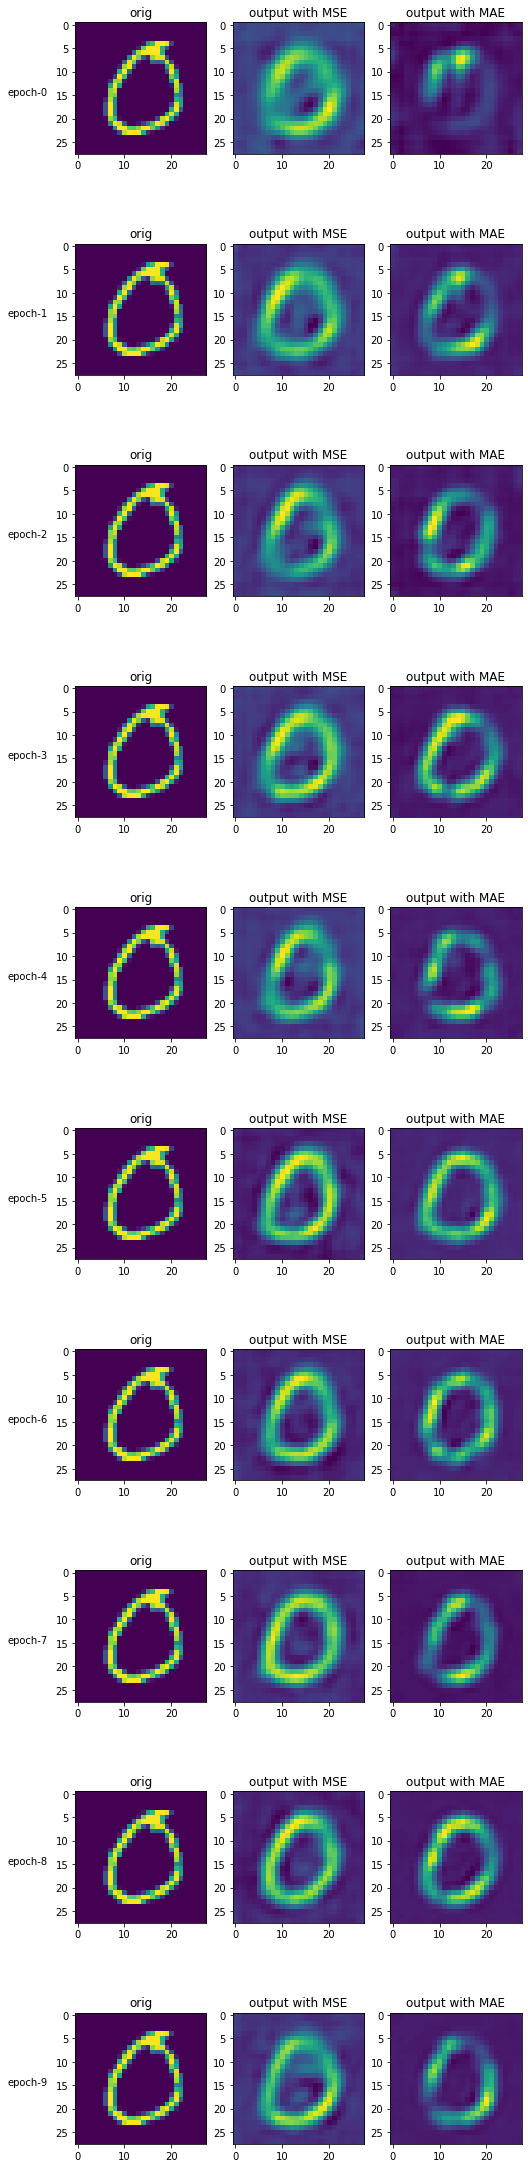

In [24]:
def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(mu))
    return torch.distributions.kl_divergence(p, q).mean()

p_exmpl=numpy.random.randint(10000)

# hyperparams
input_channels = 1
inp_dim = 28 * 28
batch_size = 128
n_epochs=10
hidden_channels=64

fig, ax = plt.subplots(nrows=n_epochs, ncols=3)   
fig.set_size_inches(8, n_epochs*4)


loss_func1 = nn.MSELoss() #TODO try to use MAE
loss_func2 = nn.L1Loss() #TODO try to use MAE

model1 = ConvVAEv2(input_channels, hidden_channels).to(device)
optim1 = torch.optim.Adam(model1.parameters())
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim1.zero_grad()
        inputs = inputs.to(device)
        predict, mu, sigma = model1(inputs)
        loss = loss_func1(inputs, predict) + 0.01 * kl_loss(mu, sigma)
        loss.backward()
        optim1.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[p_exmpl][0].unsqueeze(0).to(device).float()
    ax[epoch][0].imshow(item.squeeze().squeeze().cpu().detach().numpy())
    ax[epoch][0].text(-15, 15, 'epoch-'+str(epoch))
    ax[epoch][1].imshow(model1(item)[0].squeeze().squeeze().cpu().detach().numpy())
    ax[epoch][0].set_title('orig')
    ax[epoch][1].set_title('output with MSE')
    #break

model2 = ConvVAEv2(input_channels, hidden_channels).to(device)
optim2 = torch.optim.Adam(model2.parameters())
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim2.zero_grad()
        inputs = inputs.to(device)
        predict, mu, sigma = model2(inputs)
        loss = loss_func2(inputs, predict) + 0.01 * kl_loss(mu, sigma)
        loss.backward()
        optim2.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[p_exmpl][0].unsqueeze(0).to(device).float()
    ax[epoch][2].imshow(model2(item)[0].squeeze().squeeze().cpu().detach().numpy())
    ax[epoch][2].set_title('output with MAE')
    #break
plt.show()   

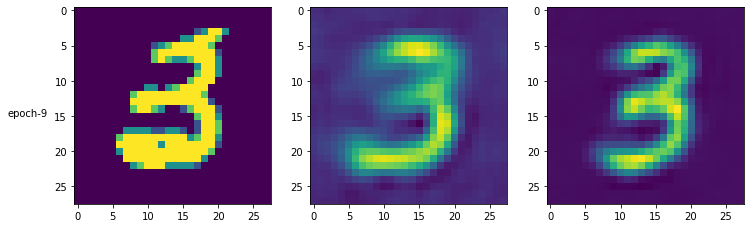

In [43]:
import numpy
p_exmpl=numpy.random.randint(10000)
fig, ax = plt.subplots(nrows=1, ncols=3)   
fig.set_size_inches(12, 4)

item = dataset_test[p_exmpl][0].unsqueeze(0).to(device).float()
ax[0].imshow(item.squeeze().squeeze().cpu().detach().numpy())
ax[0].text(-10, 15, 'epoch-'+str(epoch))
ax[1].imshow(model1(item)[0].squeeze().squeeze().cpu().detach().numpy())
ax[2].imshow(model2(item)[0].squeeze().squeeze().cpu().detach().numpy())

tensor([[[[-1.6893,  0.6171],
          [-0.4451,  0.5770]]]], device='cuda:0')
tensor([[[[-0.2434, -1.5316],
          [-0.6439,  0.1437]]]], device='cuda:0')
tensor([[[[ 0.1310,  0.1778],
          [ 0.3740, -2.1596]]]], device='cuda:0')
tensor([[[[ 0.3017, -0.5167],
          [ 0.6177, -0.2064]]]], device='cuda:0')


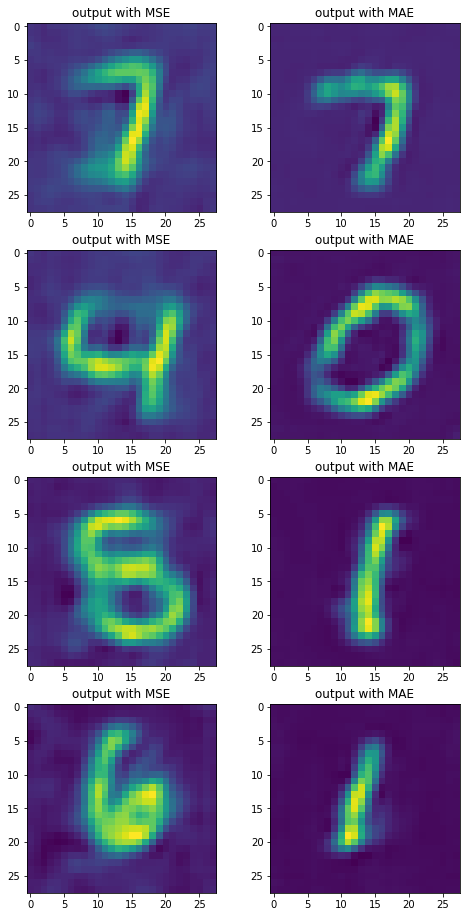

In [53]:
item = dataset_test[555][0].unsqueeze(0).to(device).float()
mu, sigma = model1.encoder(item)

size=2
n=4

fig, ax = plt.subplots(nrows=n, ncols=2)   
fig.set_size_inches(8, 4*n)

for i in range(n):
    hid = torch.normal(torch.zeros((1,1,size,size)), torch.ones((1,1,size,size))).to(device) 
    print(hid)
    ax[i][0].imshow(model1.decoder(hid).squeeze().squeeze().cpu().detach().numpy())
    ax[i][0].set_title('output with MSE')
    ax[i][1].imshow(model2.decoder(hid).squeeze().squeeze().cpu().detach().numpy())
    ax[i][1].set_title('output with MAE')
plt.show()

In [ ]:
print (model1)

ConvVAE(
  (encoder): ConvVAEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (do1): Dropout(p=0.1, inplace=False)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (do2): Dropout(p=0.1, inplace=False)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_mu): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_sigma): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activ): ReLU()
  )
  (decoder): ConvDecoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (do1): Dropout(p=0.1, inplace=False)
    (upsample1): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (do2): Dropout(p=0.1, inplace=False)
    (upsample2): Upsampli